In [1]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import os

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_train = pd.read_csv('./Resources/train.csv')
df_test = pd.read_csv('./Resources/test.csv')

In [3]:
df_train.Functional.isna().sum()

0

In [4]:
print ("In Train Dataset: ",df_train.shape[0],"sales, and ",df_train.shape[1] - 1,"features")
print ("In Test Dataset: ",df_test.shape[0],"sales, and ",df_test.shape[1],"features")

In Train Dataset:  1460 sales, and  80 features
In Test Dataset:  1459 sales, and  80 features


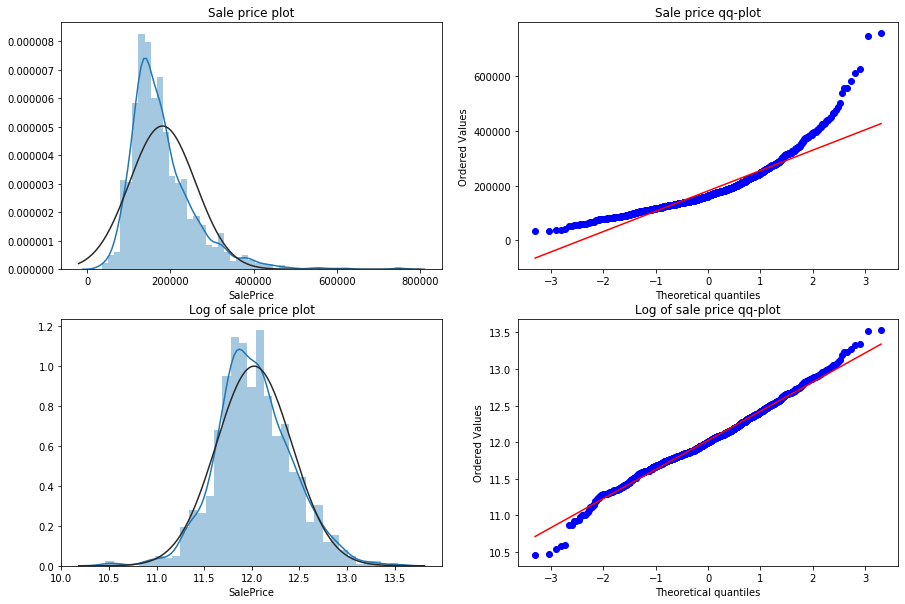

In [16]:
# normality test
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = False, sharey = False, figsize = (15,10))
sns.distplot(df_train['SalePrice'], fit=norm, ax = ax1)
ax1.set_title('Sale price plot')
stats.probplot(df_train['SalePrice'], plot = ax2)
ax2.set_title('Sale price qq-plot')
sns.distplot(np.log1p(df_train['SalePrice']), fit=norm, ax = ax3)
ax3.set_title('Log of sale price plot')
stats.probplot(np.log1p(df_train['SalePrice']), plot = ax4)
ax4.set_title('Log of sale price qq-plot')
plt.savefig("./output/png/sale_price_normal.png", bbox_inches = 'tight', dpi = 300)
plt.show()

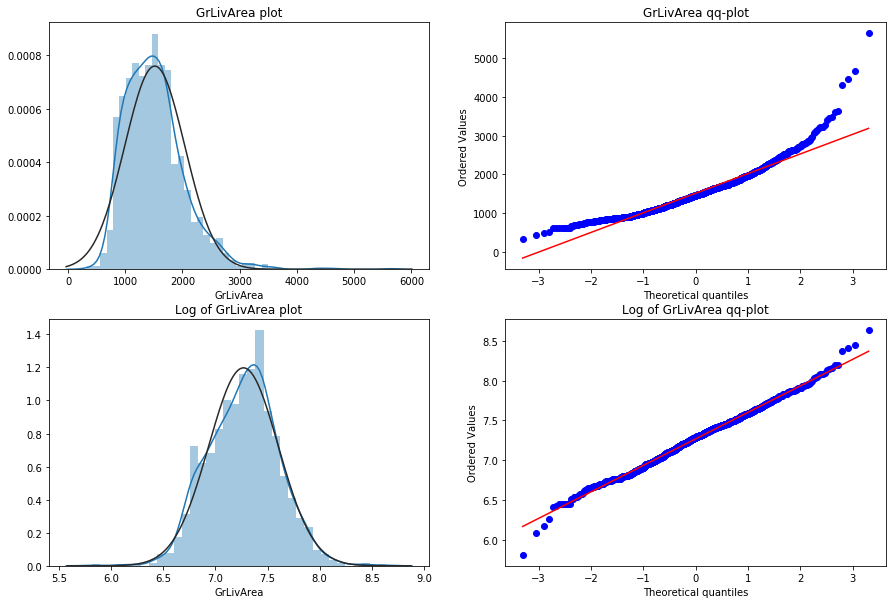

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = False, sharey = False, figsize = (15,10))
sns.distplot(df_train['GrLivArea'], fit=norm, ax = ax1)
ax1.set_title('GrLivArea plot')
stats.probplot(df_train['GrLivArea'], plot = ax2)
ax2.set_title('GrLivArea qq-plot')
sns.distplot(np.log1p(df_train['GrLivArea']), fit=norm, ax = ax3)
ax3.set_title('Log of GrLivArea plot')
stats.probplot(np.log1p(df_train['GrLivArea']), plot = ax4)
ax4.set_title('Log of GrLivArea qq-plot')
plt.savefig("./output/png/GrLivArea_normal.png", bbox_inches = 'tight', dpi = 300)
plt.show()

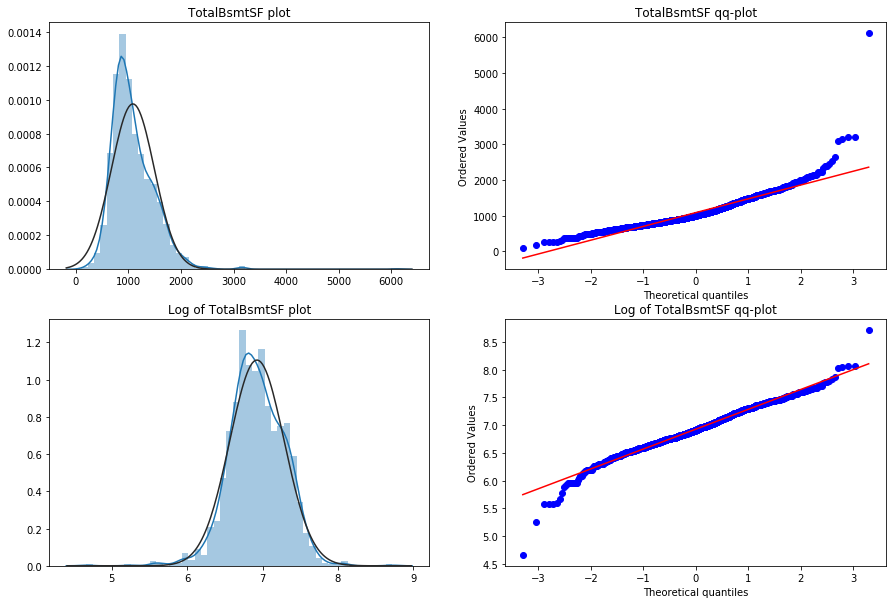

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = False, sharey = False, figsize = (15,10))
sns.distplot(df_train.loc[df_train['TotalBsmtSF']>0,['TotalBsmtSF']], fit=norm, ax = ax1)
ax1.set_title('TotalBsmtSF plot')
stats.probplot((df_train.loc[df_train['TotalBsmtSF']>0,:])['TotalBsmtSF'], plot = ax2)
ax2.set_title('TotalBsmtSF qq-plot')
sns.distplot(np.log1p(df_train.loc[df_train['TotalBsmtSF']>0,['TotalBsmtSF']]), fit=norm, ax = ax3)
ax3.set_title('Log of TotalBsmtSF plot')
stats.probplot(np.log1p((df_train.loc[df_train['TotalBsmtSF']>0,:])['TotalBsmtSF']), plot = ax4)
ax4.set_title('Log of TotalBsmtSF qq-plot')
plt.savefig("./output/png/TotalBsmtSF_normal.png", bbox_inches = 'tight', dpi = 300)
plt.show()

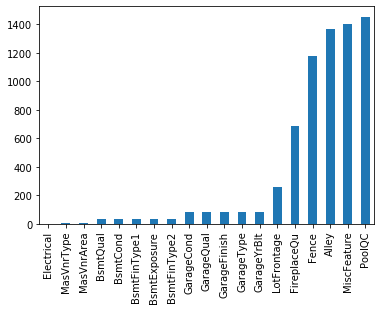

In [19]:
# missing value test
missing = df_train.isna().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.savefig("./output/png/missing_value.png", bbox_inches = 'tight', dpi = 300)
plt.show()

In [5]:
# missing value filling based on description
train_features = df_train.drop(['SalePrice'], axis = 1)
# put together of train and test to have same dummy variables
features = pd.concat([train_features, df_test]).reset_index(drop=True)
df_list = [features]
for i in df_list:
    # Functional : NA means typical
    i['Functional'] = i['Functional'].fillna('Typ')
    # Electrical : It has one NA value. Fill with most common one
    i['Electrical'] = i['Electrical'].fillna("SBrkr") 
    # KitchenQual: It has one NA value, Fill with most common one 
    i['KitchenQual'] = i['KitchenQual'].fillna("TA")
    # PoolQC : NA means "No Pool".
    i["PoolQC"] = i["PoolQC"].fillna("None")
    # MiscFeature : NA means "no misc feature"
    i["MiscFeature"] = i["MiscFeature"].fillna("None")
    # Alley : NA means "no alley access"
    i["Alley"] = i["Alley"].fillna("None")
    # Fence : NA means "no fence"
    i["Fence"] = i["Fence"].fillna("None")
    # FireplaceQu : NA means "no fireplace"
    i["FireplaceQu"] = i["FireplaceQu"].fillna("None")
    # LotFrontage : Since the area of each street connected to the house property 
    # most likely have a similar area to other houses in its neighborhood , 
    # we can fill in missing values by the median LotFrontage of the neighborhood.
    i['LotFrontage'] = i.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    # Exterior1st and Exterior2nd have only one missing value. Fill with most common one
    i['Exterior1st'] = i['Exterior1st'].fillna(i['Exterior1st'].mode()[0]) 
    i['Exterior2nd'] = i['Exterior2nd'].fillna(i['Exterior2nd'].mode()[0])
    # SaleType : Fill with most common one
    i['SaleType'] = i['SaleType'].fillna(i['SaleType'].mode()[0])
    # GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 
    #(Since No garage = no cars in such garage).
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        i[col] = i[col].fillna(0)
    # GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        i[col] = i[col].fillna('None')
    # BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
    # missing values are likely zero for having no basement
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        i[col] = i[col].fillna(0)
    # BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 
    # For all these categorical basement-related features, NaN means that there is no basement.
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        i[col] = i[col].fillna('None')
    # MSZoning (The general zoning classification) : 'RL' is by far the most common value. 
    # So we can fill in missing values with 'RL'
    i['MSZoning'] = i.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    # MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. 
    # We can fill 0 for the area and None for the type.
    i["MasVnrType"] = i["MasVnrType"].fillna("None")
    i["MasVnrArea"] = i["MasVnrArea"].fillna(0)

In [6]:
# feature drop and add
for i in df_list:
    # Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA
    i.drop(['Id', 'Utilities'], axis=1, inplace=True)
    i['YrBltAndRemod']=i['YearBuilt']+i['YearRemodAdd']
    i['TotalSF']=i['TotalBsmtSF'] + i['1stFlrSF'] + i['2ndFlrSF']
    i['Total_sqr_footage'] = (i['BsmtFinSF1'] + i['BsmtFinSF2'] + i['1stFlrSF'] + i['2ndFlrSF'])
    i['Total_Bathrooms'] = (i['FullBath'] + (0.5 * i['HalfBath']) + i['BsmtFullBath'] + (0.5 * i['BsmtHalfBath']))
    i['Total_porch_sf'] = (i['OpenPorchSF'] + i['3SsnPorch'] + i['EnclosedPorch'] + i['ScreenPorch'] + i['WoodDeckSF'])
    i['haspool'] = i['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    i['has2ndfloor'] = i['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    i['hasgarage'] = i['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    i['hasbsmt'] = i['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    i['hasfireplace'] = i['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
# normalized all the features by box-cox
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [8]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
final_features = pd.get_dummies(features).reset_index(drop=True)
target = df_train['SalePrice'].reset_index(drop=True)
train_final = final_features.iloc[:len(target), :]
test_final = final_features.iloc[len(target):, :]
train_final['SalePrice'] = df_train['SalePrice']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
# delete the outlier
train_final = train_final.drop(train_final[(train_final['GrLivArea']>4000) & (train_final['SalePrice']<300000)].index)

In [10]:
# final features to delete outlier and output the csv
train_final['SalePrice'] = np.log1p(train_final['SalePrice'])
outliers = [30, 88, 462, 631, 1322]
train_final = train_final.drop(outliers)
train_final.to_csv('./output/csv/train_engineer.csv', index = False)
test_final.to_csv('./output/csv/test_engineer.csv', index = False)